<a href="https://colab.research.google.com/github/gorozco21/streamlit-example/blob/master/Gamma_Delta_CBOE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd
import re
import matplotlib.pyplot as plt
from IPython.display import Image, display
import numpy as np

<ipython-input-9-3565f59b0838>:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['symbol'] = symbol


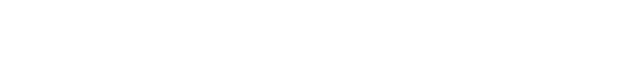

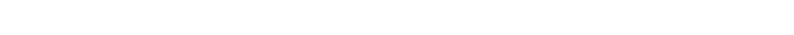

styled_image.png
Error al enviar la imagen: 200


In [9]:
# Clave de API de Tradier
api_key = 'kLtiHlJBYMfZ7WAyn0tPqGB75gHn'

# Añade aquí los símbolos de los stocks que te interesan
symbols = ['AAPL']
#symbols = ['_SPX']
#symbols = ['SPX', 'AAPL',  'AMZN',  'CMG',  'COIN',  'ENPH',  'GOOGL',  'GS',  'HD',  'MDB',  'MRNA',  'NVDA',  'PFE',  'QQQ',  'SPY',  'TSLA',  'V',  'XLE',  'XLF',  'XLV']

# URL base para la cadena de opciones (ajústala según la API correcta que estés usando)
url_base = 'https://cdn.cboe.com/api/global/delayed_quotes/options/'

# Lista para almacenar DataFrames
dfs = []

for symbol in symbols:
    # Construir la URL completa para la solicitud de la API
    url_chain = f'{url_base}{symbol}.json'

    # Realizar la solicitud GET a la API
    try:
        response = requests.get(url_chain)
        response.raise_for_status()  # Lanza un error para estados de respuesta 4xx/5xx
    except requests.RequestException as e:
        print(f"Error al solicitar datos para {symbol}: {e}")
        continue

    # Analizar la respuesta JSON
    data = response.json()

    # Extraer la lista de opciones
    options_list = data['data']['options']

    # Convertir a DataFrame de pandas
    df = pd.DataFrame(options_list)

    # Define the combined DataFrame for calls and puts
    # Función para determinar el tipo de opción
    def get_option_type(option_id):
        # Busca la primera 'C' o 'P' desde el final del string
        match = re.search(r'[CP](?!.*[CP])', option_id)
        if match:
            return 'call' if match.group() == 'C' else 'put'
        else:
            return 'unknown'  # Devuelve 'unknown' si no se encuentra ninguna 'C' o 'P'

    def get_option_segments(option_id):
        # Busca la primera 'C' o 'P' desde el final del string
        match = re.search(r'[CP](?!.*[CP])', option_id)
        if match:
            # Encuentra el índice de la primera 'C' o 'P' encontrada
            index = match.start()
            # Devuelve el segmento antes de 'C'/'P' y el segmento después
            return option_id[:index], option_id[index+1:]
        else:
            # Devuelve 'unknown' para ambos segmentos si no se encuentra 'C' o 'P'
            return 'unknown', 'unknown'

    def get_last_price_tradier(symbol):

        # Endpoint para obtener cotizaciones
        url = f'https://api.tradier.com/v1/markets/quotes?symbols={symbol}'

        # Encabezados necesarios para la solicitud
        headers = {
            'Authorization': f'Bearer {api_key}',
            'Accept': 'application/json'
        }

        try:
            # Realizar la solicitud GET
            response = requests.get(url, headers=headers)
            response.raise_for_status()  # Lanza un error para respuestas no exitosas
            # Procesar la respuesta JSON
            data = response.json()
            # Extraer el último precio
            last_price = data['quotes']['quote']['last']
            return last_price
        except requests.RequestException as e:
            print(f"Error al solicitar el último precio para {symbol}: {e}")
            return None

    df['last_price'] = get_last_price_tradier(symbol)

    df['GEX'] = df['last_price'] * df['open_interest'] * df['gamma']
    df['DEX'] = df['last_price'] * df['open_interest'] * df['delta']

    # Aplicar la función al DataFrame y expandir el resultado en dos nuevas columnas
    df[['col1', 'col2']] = df['option'].apply(lambda x: pd.Series(get_option_segments(x)))

    # Agregar una nueva columna 'option_type' usando la función definida
    df['option_type'] = df['option'].apply(get_option_type)

    calls_df = df[df['option_type'] == 'call']
    puts_df = df[df['option_type'] == 'put']
    combined_df = pd.merge(calls_df, puts_df, on=["col1", "col2", "last_price"], suffixes=('_c', '_p'))

    df3 = combined_df[['col1', 'col2', 'last_price', 'GEX_c', 'DEX_c', 'GEX_p', 'DEX_p']]
    df3['symbol'] = symbol

    df3 = df3.groupby('symbol').agg({'last_price': 'mean', 'DEX_c': 'sum', 'GEX_c': 'sum', 'DEX_p': 'sum', 'GEX_p': 'sum'}).reset_index()
    df3['SpotGEX'] = df3['GEX_c'] + df3['GEX_p']
    df3['SpotDEX'] = df3['DEX_c'] + df3['DEX_p']

    # Append df3 to dfs
    dfs.append(df3)

# Combine all DataFrames
combined_df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# Redondear los números a dos decimales
combined_df = combined_df.round(0)

# Convertir cada columna a enteros si es posible
##for column in combined_df.columns:
    # Verificar si la columna puede ser convertida a int
##    if pd.api.types.is_float_dtype(combined_df[column]):
##        combined_df[column] = combined_df[column].astype(int)

figsize = (8, len(combined_df) * 0.5)  # Ajusta el alto dinámicamente basado en el número de filas
##header_color = '#6C7A89'  # Color de fondo para los encabezados más claro
##row_colors = ['#f1f1f2', 'w']  # Colores alternos para las filas

plt.figure(figsize=figsize)
ax = plt.subplot(111, frame_on=False)  # No queremos marco visible
ax.xaxis.set_visible(False)  # Ocultar el eje X
ax.yaxis.set_visible(False)  # Ocultar el eje Y

# Asegurarse de que solo se usen los valores de las celdas sin índices
cell_text = combined_df.values.tolist()  # Convertir los valores del DataFrame a una lista de listas

def color_value(val, min_val, max_val):
    try:
        val = float(val)
        min_val = float(min_val)
        max_val = float(max_val)
    except ValueError:
        return 'background-color: none'  # Si no es un número, no se aplica color

    if val == 0:
        color = 'white'  # Blanco para el valor 0
    else:
        proportion = (val - min_val) / (max_val - min_val) if max_val != min_val else 1
        green = int(255 * proportion)
        red = 255 - green
        color = f'rgb({red},{green},0)'
    return f'background-color: {color}'

# Genera la imagen con matplotlib
fig, ax = plt.subplots(figsize=(10, len(combined_df) * 0.2))  # Ajusta el tamaño de la figura
ax.axis('off')

# Crear la tabla con colores
cell_text = []
for row in range(len(combined_df)):
    cell_text.append([])
    for col in combined_df.columns:
        val = combined_df.iloc[row][col]
        cell_text[row].append(f'{val}')
cell_colours = []
for col in combined_df.columns:
    col_values = combined_df[col].values
    min_val = np.min(col_values)
    max_val = np.max(col_values)
    cell_colours.append([color_value(val, min_val, max_val) for val in col_values])


plt.savefig('styled_image.png')
plt.show()

# Muestra la imagen guardada
display(Image(filename='styled_image.png'))
print('styled_image.png')

# URL de webhook de Discord - Desarrollo
webhook_url = "https://discord.com/api/webhooks/1090845494919569509/FbLOpKFVpg3dt_kTzsQVdjm1tbCAHGB39gReeg08O-HjhWIN0_QECIDrKxO515v-czH6"

# URL de webhook de Discord - Producción
#webhook_url = "https://discord.com/api/webhooks/1082801469738201119/nsRi33z37wp0O2HJfEYAo-gtTcYBUjAOQanHT8M2WD5KvW8YP4DY04awyoMG_8O-tb7X"

file = {'file': open('styled_image.png', 'rb')}

#response = requests.post(webhook_url, files=file)

# Verificar si la solicitud fue exitosa
if response.status_code == 204:
    print("Imagen enviada con éxito.")
else:
    print(f"Error al enviar la imagen: {response.status_code}")

styled_image.png
Error al enviar la imagen: 200


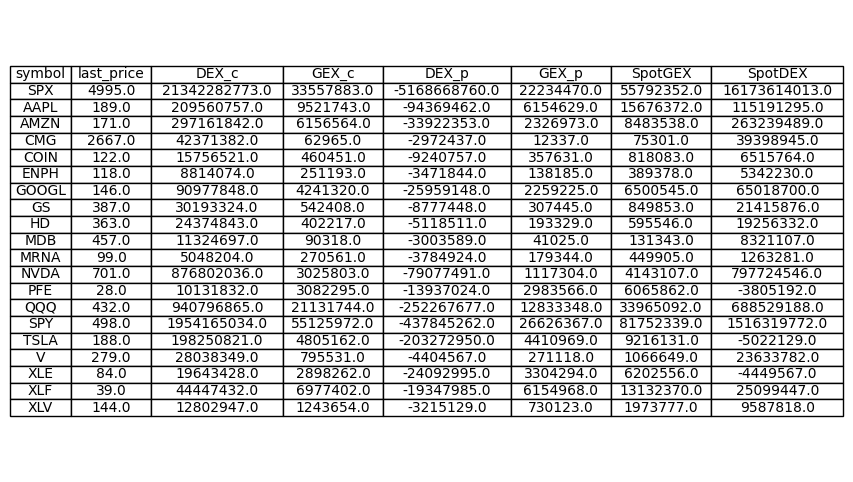

In [27]:
# Clave de API de Tradier
api_key = 'kLtiHlJBYMfZ7WAyn0tPqGB75gHn'

# Añade aquí los símbolos de los stocks que te interesan
#symbols = ['AAPL', 'AMZN']
#symbols = ['_SPX']
symbols = ['SPX', 'AAPL',  'AMZN',  'CMG',  'COIN',  'ENPH',  'GOOGL',  'GS',  'HD',  'MDB',  'MRNA',  'NVDA',  'PFE',  'QQQ',  'SPY',  'TSLA',  'V',  'XLE',  'XLF',  'XLV']

# URL base para la cadena de opciones (ajústala según la API correcta que estés usando)
url_base = 'https://cdn.cboe.com/api/global/delayed_quotes/options/'

# Lista para almacenar DataFrames
dfs = []

for symbol in symbols:
    # Construir la URL completa para la solicitud de la API
    url_chain = f'{url_base}_{"SPX"}.json' if symbol == 'SPX' else f'{url_base}{symbol}.json'

    # Realizar la solicitud GET a la API
    try:
        response = requests.get(url_chain)
        response.raise_for_status()  # Lanza un error para estados de respuesta 4xx/5xx
    except requests.RequestException as e:
        print(f"Error al solicitar datos para {symbol}: {e}")
        continue

    # Analizar la respuesta JSON
    data = response.json()

    # Extraer la lista de opciones
    options_list = data['data']['options']

    # Convertir a DataFrame de pandas
    df = pd.DataFrame(options_list)

    # Define the combined DataFrame for calls and puts
    # Función para determinar el tipo de opción
    def get_option_type(option_id):
        # Busca la primera 'C' o 'P' desde el final del string
        match = re.search(r'[CP](?!.*[CP])', option_id)
        if match:
            return 'call' if match.group() == 'C' else 'put'
        else:
            return 'unknown'  # Devuelve 'unknown' si no se encuentra ninguna 'C' o 'P'

    def get_option_segments(option_id):
        # Busca la primera 'C' o 'P' desde el final del string
        match = re.search(r'[CP](?!.*[CP])', option_id)
        if match:
            # Encuentra el índice de la primera 'C' o 'P' encontrada
            index = match.start()
            # Devuelve el segmento antes de 'C'/'P' y el segmento después
            return option_id[:index], option_id[index+1:]
        else:
            # Devuelve 'unknown' para ambos segmentos si no se encuentra 'C' o 'P'
            return 'unknown', 'unknown'

    def get_last_price_tradier(symbol):

        # Endpoint para obtener cotizaciones
        url = f'https://api.tradier.com/v1/markets/quotes?symbols={symbol}'

        # Encabezados necesarios para la solicitud
        headers = {
            'Authorization': f'Bearer {api_key}',
            'Accept': 'application/json'
        }

        try:
            # Realizar la solicitud GET
            response = requests.get(url, headers=headers)
            response.raise_for_status()  # Lanza un error para respuestas no exitosas
            # Procesar la respuesta JSON
            data = response.json()
            # Extraer el último precio
            last_price = data['quotes']['quote']['last']
            return last_price
        except requests.RequestException as e:
            print(f"Error al solicitar el último precio para {symbol}: {e}")
            return None

    df['last_price'] = get_last_price_tradier(symbol)

    df['GEX'] = df['last_price'] * df['open_interest'] * df['gamma']
    df['DEX'] = df['last_price'] * df['open_interest'] * df['delta']

    # Aplicar la función al DataFrame y expandir el resultado en dos nuevas columnas
    df[['col1', 'col2']] = df['option'].apply(lambda x: pd.Series(get_option_segments(x)))

    # Agregar una nueva columna 'option_type' usando la función definida
    df['option_type'] = df['option'].apply(get_option_type)

    calls_df = df[df['option_type'] == 'call']
    puts_df = df[df['option_type'] == 'put']
    combined_df = pd.merge(calls_df, puts_df, on=["col1", "col2", "last_price"], suffixes=('_c', '_p'))

    df3 = combined_df[['col1', 'col2', 'last_price', 'GEX_c', 'DEX_c', 'GEX_p', 'DEX_p']]
    df3 = df3.copy()
    df3.loc[:, 'symbol'] = symbol

    df3 = df3.groupby('symbol').agg({'last_price': 'mean', 'DEX_c': 'sum', 'GEX_c': 'sum', 'DEX_p': 'sum', 'GEX_p': 'sum'}).reset_index()
    df3['SpotGEX'] = df3['GEX_c'] + df3['GEX_p']
    df3['SpotDEX'] = df3['DEX_c'] + df3['DEX_p']

    # Append df3 to dfs
    dfs.append(df3)

# Combine all DataFrames
combined_df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# Redondear los números a dos decimales
combined_df = combined_df.round(0)

#Nuevo- Desde
# Configuración básica de la figura
plt.figure(figsize=(10, 0.3 * len(combined_df)))
ax = plt.gca()
ax.axis('off')

# Creación de la tabla
table = ax.table(cellText=combined_df.values, colLabels=combined_df.columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(combined_df.columns))))

# Ajuste de la escala de la tabla
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

# Guardar la figura
plt.savefig('styled_image.png', bbox_inches='tight', dpi=150)
print('styled_image.png')

# URL de webhook de Discord - Desarrollo
webhook_url = "https://discord.com/api/webhooks/1090845494919569509/FbLOpKFVpg3dt_kTzsQVdjm1tbCAHGB39gReeg08O-HjhWIN0_QECIDrKxO515v-czH6"

# URL de webhook de Discord - Producción
#webhook_url = "https://discord.com/api/webhooks/1082801469738201119/nsRi33z37wp0O2HJfEYAo-gtTcYBUjAOQanHT8M2WD5KvW8YP4DY04awyoMG_8O-tb7X"

file = {'file': open('styled_image.png', 'rb')}

#response = requests.post(webhook_url, files=file)

# Verificar si la solicitud fue exitosa
if response.status_code == 204:
    print("Imagen enviada con éxito.")
else:
    print(f"Error al enviar la imagen: {response.status_code}")

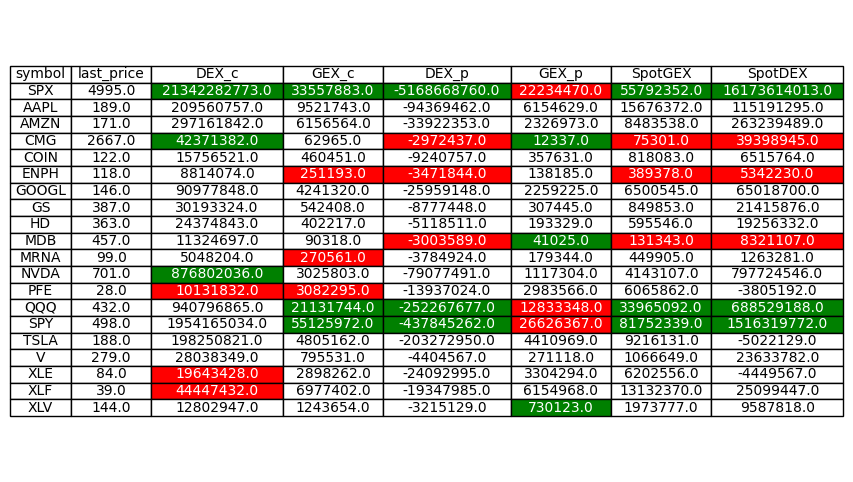

In [29]:
# Configuración básica de la figura
plt.figure(figsize=(10, 0.3 * len(combined_df)))
ax = plt.gca()
ax.axis('off')

# Creación de la tabla
table = ax.table(cellText=combined_df.values, colLabels=combined_df.columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(combined_df.columns))))

# Iterar sobre las celdas para aplicar el formateo condicional, excluyendo las primeras dos columnas
for (i, j), cell in table.get_celld().items():
    if i > 0 and j > 1:  # Ignorar la fila de encabezados y las primeras dos columnas
        value = combined_df.iloc[i-1, j-1]  # Ajustar índices para los valores de DataFrame
        if value == 0:
            cell.set_facecolor('white')  # Fondo blanco para valor 0
        elif value in combined_df.nlargest(3, combined_df.columns[j-1])[combined_df.columns[j-1]].values:
            cell.set_facecolor('green')  # Fondo verde para los tres mayores
            cell.set_text_props(color='white')  # Texto blanco para mayor contraste
        elif value in combined_df.nsmallest(3, combined_df.columns[j-1])[combined_df.columns[j-1]].values:
            cell.set_facecolor('red')  # Fondo rojo para los tres menores
            cell.set_text_props(color='white')  # Texto blanco para mayor contraste

# Ajuste de la escala de la tabla
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

# Guardar la figura
plt.savefig('styled_image_conditional_formatting.png', bbox_inches='tight', dpi=150)


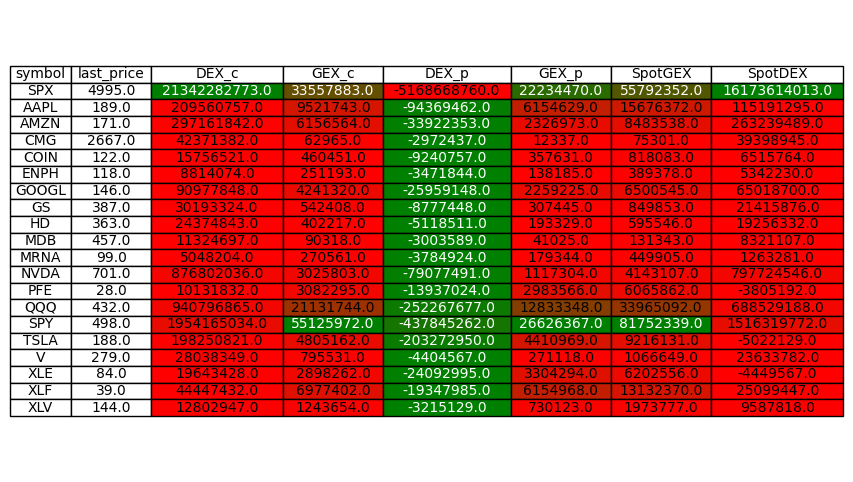

In [30]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Configuración básica de la figura
plt.figure(figsize=(10, 0.3 * len(combined_df)))
ax = plt.gca()
ax.axis('off')

# Creación de la tabla
table = ax.table(cellText=combined_df.values, colLabels=combined_df.columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(combined_df.columns))))

# Definir el mapa de colores para el gradiente
cmap = mcolors.LinearSegmentedColormap.from_list("", ["red", "green"])

# Aplicar el gradiente a cada columna, excluyendo las primeras dos columnas
for j in range(2, len(combined_df.columns)):  # Comenzar desde la tercera columna
    column_values = combined_df.iloc[:, j].values
    min_val, max_val = np.min(column_values), np.max(column_values)

    for i in range(len(combined_df)):
        value = column_values[i]
        # Normalizar el valor dentro del rango de la columna
        normalized = (value - min_val) / (max_val - min_val) if max_val != min_val else 0.5
        # Obtener el color correspondiente del mapa de colores
        color = cmap(normalized)
        # Aplicar el color a la celda
        table[(i+1, j)].set_facecolor(color)
        table[(i+1, j)].set_text_props(color='white' if normalized > 0.5 else 'black')  # Ajustar color del texto para contraste

# Ajuste de la escala de la tabla
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

# Guardar la figura
plt.savefig('styled_image_gradient.png', bbox_inches='tight', dpi=150)


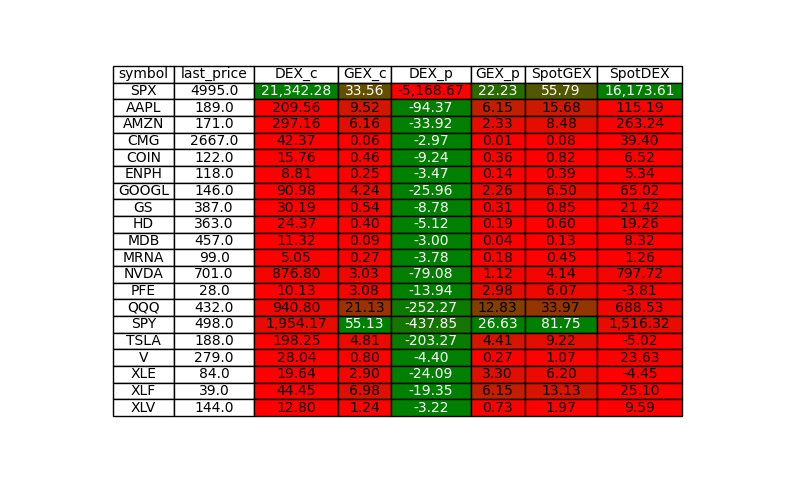

In [45]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Configuración básica de la figura
plt.figure(figsize=(10, 0.3 * len(combined_df)))
ax = plt.gca()
ax.axis('off')

# Creación de la tabla
table = ax.table(cellText=combined_df.values, colLabels=combined_df.columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(combined_df.columns))))

# Definir el mapa de colores para el gradiente
cmap = mcolors.LinearSegmentedColormap.from_list("", ["red", "green"])

# Aplicar el gradiente a cada columna, excluyendo las primeras dos columnas
for j in range(2, len(combined_df.columns)):  # Comenzar desde la tercera columna
    # Convertir los valores a flotantes después de eliminar las comas
    column_values = combined_df.iloc[:, j].str.replace(',', '').astype(float)
    min_val, max_val = np.min(column_values[column_values != 0]), np.max(column_values)

    for i in range(len(combined_df)):
        value = column_values[i]
        if value == 0:
            color = 'white'  # Blanco específicamente para 0
        else:
            # Normalizar el valor dentro del rango de la columna, excluyendo 0
            normalized = (value - min_val) / (max_val - min_val) if max_val != min_val else 0.5
            # Obtener el color correspondiente del mapa de colores
            color = cmap(normalized)

        # Aplicar el color a la celda
        table[(i+1, j)].set_facecolor(color)
        # Ajustar color del texto para contraste
        table[(i+1, j)].set_text_props(color='black' if value == 0 or normalized < 0.5 else 'white')

        # Formatear el valor para la visualización
        formatted_value = format_value(value)
        # Actualizar el texto de la celda con el valor formateado
        table[(i+1, j)].get_text().set_text(formatted_value)

# Ajuste de la escala de la tabla
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

# Guardar la figura
plt.savefig('styled_image_gradient_formatted_corrected.png', bbox_inches='tight', dpi=150)


La imagen se ha guardado como "styled_image.png"
  symbol  last_price        DEX_c      GEX_c       DEX_p      GEX_p  \
0   AAPL       189.0  209560757.0  9521743.0 -94369462.0  6154629.0   

      SpotGEX      SpotDEX  
0  15676372.0  115191295.0  


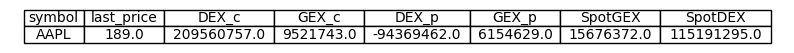

In [18]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Clave de API de Tradier
api_key = 'kLtiHlJBYMfZ7WAyn0tPqGB75gHn'

# Símbolos de los stocks que te interesan
symbols = ['AAPL', 'AMZN', 'TSLA']  # Ejemplo con menos símbolos para simplificar

# URL base para la cadena de opciones
url_base = 'https://api.tradier.com/v1/markets/options/chains'

# Lista para almacenar DataFrames
dfs = []

for symbol in symbols:
    # Parámetros para la solicitud GET a la API de Tradier
    params = {
        'symbol': symbol,
        'expiration': '2024-01-19'  # Fecha de vencimiento de ejemplo
    }
    headers = {
        'Authorization': f'Bearer {api_key}',
        'Accept': 'application/json'
    }

    # Realizar la solicitud GET a la API de Tradier
    try:
        response = requests.get(url_base, headers=headers, params=params)
        response.raise_for_status()  # Lanza un error para estados de respuesta 4xx/5xx
        data = response.json()

        # Suponiendo que 'options' es la clave donde se encuentran los datos de las opciones
        options_list = data.get('options', {}).get('option', [])

        if options_list:
            # Convertir a DataFrame de pandas
            df = pd.DataFrame(options_list)
            df['symbol'] = symbol  # Asignar símbolo sin generar SettingWithCopyWarning
            dfs.append(df)
        else:
            print(f"No se encontraron opciones para {symbol}")
    except requests.RequestException as e:
        print(f"Error al solicitar datos para {symbol}: {e}")

# Combinar todos los DataFrames
combined_df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# Verificación: Imprimir los primeros registros para asegurar que los datos son correctos
print(combined_df.head())

# Creación de la visualización con Matplotlib
if not combined_df.empty:
    fig, ax = plt.subplots(figsize=(10, 0.3 * len(combined_df)))
    ax.axis('off')
    table = ax.table(cellText=combined_df.values, colLabels=combined_df.columns, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(combined_df.columns))))
    plt.savefig('styled_image.png', bbox_inches='tight', dpi=150)
    print('La imagen "styled_image.png" se ha guardado correctamente.')
else:
    print("No hay datos para generar la imagen.")


AttributeError: 'NoneType' object has no attribute 'get'

In [19]:
# Realizar la solicitud GET a la API de Tradier
try:
    response = requests.get(url_base, headers=headers, params=params)
    response.raise_for_status()  # Lanza un error para estados de respuesta 4xx/5xx
    data = response.json()

    # Verificar que data no es None y contiene la clave 'options'
    if data and 'options' in data:
        options_list = data['options'].get('option', [])
        if options_list:
            # Convertir a DataFrame de pandas
            df = pd.DataFrame(options_list)
            df['symbol'] = symbol  # Asignar símbolo sin generar SettingWithCopyWarning
            dfs.append(df)
        else:
            print(f"No se encontraron opciones para {symbol}")
    else:
        print(f"Respuesta inesperada o sin datos para {symbol}: {data}")
except requests.RequestException as e:
    print(f"Error al solicitar datos para {symbol}: {e}")


AttributeError: 'NoneType' object has no attribute 'get'